In [48]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [49]:
cm = 3
mN = 1

V2 = 1

modes_dt = {1: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 1.17e7*V2},
            2: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 1.75e3*V2}, 
            3: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': 1.22e7*V2},
            4: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': 1.77e3*V2},
            0: {'mode': f'../features/background_reco_E-{cm}TeV.root', 'yields': 1.83e5}
           }

In [50]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        df_i['target'] = k    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
#         print(k, v)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [51]:
tr_te_size = 1 
df, _ = load_train_test(modes_dt, tr_te_size)



train size: 35712 (100.00%); test size: 0 (0.00%)
data points per mode:  [5707, 6138, 5861, 6098, 11908]


In [ ]:
def relabel(x):
    if x == 0 :    # bkg
        return 0
    elif x == 1:     # t-channel signal
        return 1
    elif x == 2:    # 2-channel signal
        return 1
    elif x == 3:     # t-channel signal
        return 1
    elif x == 4:    # s-channel signal
        return 1

In [6]:
# df_cutbased = pd.DataFrame(columns=['sM', 'tM', 'sD', 'tD', 'Bkg'])
df_cutbased = pd.DataFrame(columns=['tM', 'tD', 'Bkg'])

df_b_ = df[df.target==0]
df_tM_ = df[df.target==1]
df_sM_ = df[df.target==2]
df_tD_ = df[df.target==3]
df_sD_ = df[df.target==4]

df_cutbased.loc['init'] = [df_tM_.weight.sum(), df_tD_.weight.sum(), df_b_.weight.sum()]
# df_cutbased.loc['init'] = [df_sM_.weight.sum(), df_tM_.weight.sum(), df_sD_.weight.sum(), df_tD_.weight.sum(), df_b_.weight.sum()]

t-ch (Maj):	1.17e+07 x |V|^2 -> 1.15e+07 x |V|^2	: 98.34%
t-ch (Dir):	1.22e+07 x |V|^2 -> 1.20e+07 x |V|^2	: 98.70%
Bkg:		1.83e+05	 -> 9.83e+04		: 53.74%


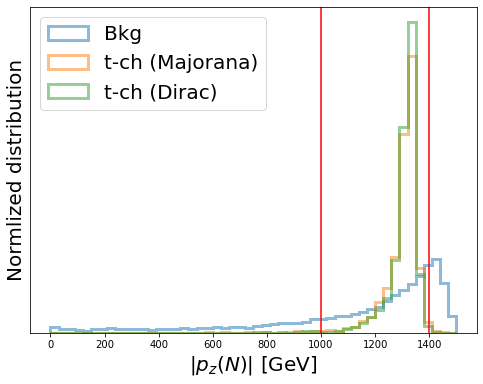

In [7]:
df_b = df_b_
df_tM = df_tM_ 
df_sM = df_sM_ 
df_tD = df_tD_
df_sD = df_sD_ 

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

col = 'pzN'
bins_=50
range_=0, 1500
ax1.hist(abs(df_b[col]), weights=[1/len(df_b)]*len(df_b), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Bkg');
ax1.hist(abs(df_tM[col]), weights=[1/len(df_tM)]*len(df_tM), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (Majorana)');
# ax1.hist(abs(df_sM[col]), weights=[1/len(df_sM)]*len(df_sM), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='s-ch (Majorana)');
ax1.hist(abs(df_tD[col]), weights=[1/len(df_tD)]*len(df_tD), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (Dirac)');
# ax1.hist(abs(df_sD[col]), weights=[1/len(df_sD)]*len(df_sD), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='s-ch (Dirac)');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$|p_z(N)| ~[\rmGeV]$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=2, fontsize=20)

c1, c2 = 1000, 1400
ax1.axvline(c1, color='red')
ax1.axvline(c2, color='red')

df_b_ = df_b[(abs(df_b[col])>c1) & (abs(df_b[col])<c2)]
df_sM_ = df_sM[(abs(df_sM[col])>c1) & (abs(df_sM[col])<c2)]
df_tM_ = df_tM[(abs(df_tM[col])>c1) & (abs(df_tM[col])<c2)]
df_sD_ = df_sD[(abs(df_sD[col])>c1) & (abs(df_sD[col])<c2)]
df_tD_ = df_tD[(abs(df_tD[col])>c1) & (abs(df_tD[col])<c2)]

# print("s-ch (Maj):\t{:.2e} x |V|^2 -> {:.2e} x |V|^2\t: {:.2f}%".format(df_sM.weight.sum(), df_sM_.weight.sum(), df_sM_.weight.sum()/df_sM.weight.sum()*100))
print("t-ch (Maj):\t{:.2e} x |V|^2 -> {:.2e} x |V|^2\t: {:.2f}%".format(df_tM.weight.sum(), df_tM_.weight.sum(), df_tM_.weight.sum()/df_tM.weight.sum()*100))
# print("s-ch (Dir):\t{:.2e} x |V|^2 -> {:.2e} x |V|^2\t: {:.2f}%".format(df_sD.weight.sum(), df_sD_.weight.sum(), df_sD_.weight.sum()/df_sD.weight.sum()*100))
print("t-ch (Dir):\t{:.2e} x |V|^2 -> {:.2e} x |V|^2\t: {:.2f}%".format(df_tD.weight.sum(), df_tD_.weight.sum(), df_tD_.weight.sum()/df_tD.weight.sum()*100))
print("Bkg:\t\t{:.2e}\t -> {:.2e}\t\t: {:.2f}%".format(df_b.weight.sum(), df_b_.weight.sum(), df_b_.weight.sum()/df_b.weight.sum()*100))

row_name = str(c1)+' < '+col+' < '+str(c2)
df_cutbased.loc[row_name] = [df_tM_.weight.sum(), df_tD_.weight.sum(), df_b_.weight.sum()]

# df_cutbased.loc[row_name] = [df_sM_.weight.sum(), df_tM_.weight.sum(), df_sD_.weight.sum(), df_tD_.weight.sum(), df_b_.weight.sum()]

t-ch (Maj):	1.15e+07 x |V|^2 -> 1.09e+07 x |V|^2	: 95.15%
t-ch (Dir):	1.20e+07 x |V|^2 -> 1.15e+07 x |V|^2	: 95.28%
Bkg:		9.83e+04	 -> 5.68e+04		: 57.79%


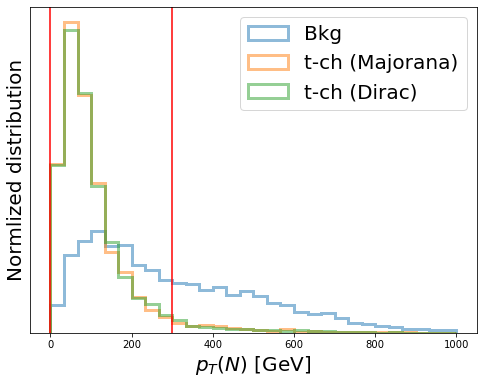

In [8]:
df_b = df_b_
df_tM = df_tM_ 
df_tD = df_tD_

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


col = 'ptN'
bins_=30
range_=0, 1000
ax1.hist(df_b[col], weights=[1/len(df_b)]*len(df_b), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Bkg');
ax1.hist(df_tM[col], weights=[1/len(df_tM)]*len(df_tM), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (Majorana)');
ax1.hist(df_tD[col], weights=[1/len(df_tD)]*len(df_tD), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (Dirac)');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$p_T(N) ~[\rmGeV]$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

c1, c2 = 0, 300
ax1.axvline(c1, color='red')
ax1.axvline(c2, color='red')

df_b_ = df_b[(df_b[col]>c1) & (df_b[col]<c2)]
df_tM_ = df_tM[(df_tM[col]>c1) & (df_tM[col]<c2)]
df_tD_ = df_tD[(df_tD[col]>c1) & (df_tD[col]<c2)]

print("t-ch (Maj):\t{:.2e} x |V|^2 -> {:.2e} x |V|^2\t: {:.2f}%".format(df_tM.weight.sum(), df_tM_.weight.sum(), df_tM_.weight.sum()/df_tM.weight.sum()*100))
print("t-ch (Dir):\t{:.2e} x |V|^2 -> {:.2e} x |V|^2\t: {:.2f}%".format(df_tD.weight.sum(), df_tD_.weight.sum(), df_tD_.weight.sum()/df_tD.weight.sum()*100))
print("Bkg:\t\t{:.2e}\t -> {:.2e}\t\t: {:.2f}%".format(df_b.weight.sum(), df_b_.weight.sum(), df_b_.weight.sum()/df_b.weight.sum()*100))

row_name = str(c1)+' < '+col+' < '+str(c2)
df_cutbased.loc[row_name] = [df_tM_.weight.sum(), df_tD_.weight.sum(), df_b_.weight.sum()]

t-ch (Maj):	1.09e+07 x |V|^2 -> 1.01e+07 x |V|^2	: 92.25%
t-ch (Dir):	1.15e+07 x |V|^2 -> 1.04e+07 x |V|^2	: 90.57%
Bkg:		5.68e+04	 -> 1.93e+04		: 34.05%


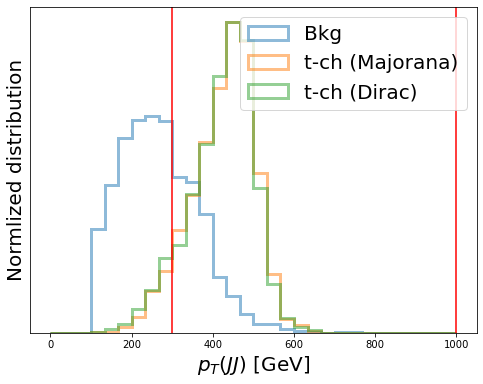

In [9]:
df_b = df_b_
df_tM = df_tM_ 
df_tD = df_tD_

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


col = 'ptJJ'
bins_=30
range_=0, 1000
ax1.hist(df_b[col], weights=[1/len(df_b)]*len(df_b), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Bkg');
ax1.hist(df_tM[col], weights=[1/len(df_tM)]*len(df_tM), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (Majorana)');
ax1.hist(df_tD[col], weights=[1/len(df_tD)]*len(df_tD), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (Dirac)');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$p_T(JJ) ~[\rmGeV]$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

c1, c2 = 300, 999
ax1.axvline(c1, color='red')
ax1.axvline(c2, color='red')

df_b_ = df_b[(df_b[col]>c1) & (df_b[col]<c2)]
df_tM_ = df_tM[(df_tM[col]>c1) & (df_tM[col]<c2)]
df_tD_ = df_tD[(df_tD[col]>c1) & (df_tD[col]<c2)]

print("t-ch (Maj):\t{:.2e} x |V|^2 -> {:.2e} x |V|^2\t: {:.2f}%".format(df_tM.weight.sum(), df_tM_.weight.sum(), df_tM_.weight.sum()/df_tM.weight.sum()*100))
print("t-ch (Dir):\t{:.2e} x |V|^2 -> {:.2e} x |V|^2\t: {:.2f}%".format(df_tD.weight.sum(), df_tD_.weight.sum(), df_tD_.weight.sum()/df_tD.weight.sum()*100))
print("Bkg:\t\t{:.2e}\t -> {:.2e}\t\t: {:.2f}%".format(df_b.weight.sum(), df_b_.weight.sum(), df_b_.weight.sum()/df_b.weight.sum()*100))

row_name = str(c1)+' < '+col+' < '+str(c2)
df_cutbased.loc[row_name] = [df_tM_.weight.sum(), df_tD_.weight.sum(), df_b_.weight.sum()]

t-ch (Maj):	1.01e+07 x |V|^2 -> 9.80e+06 x |V|^2	: 97.00%
t-ch (Dir):	1.04e+07 x |V|^2 -> 1.01e+07 x |V|^2	: 97.12%
Bkg:		1.93e+04	 -> 4.73e+03		: 24.46%


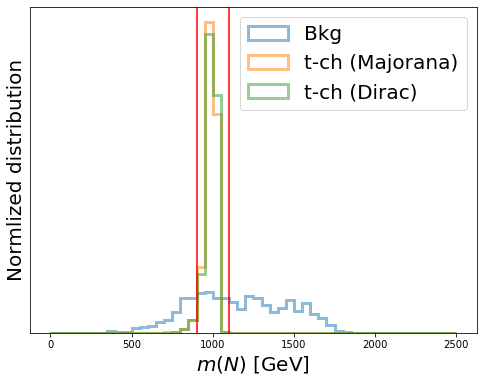

In [10]:
df_b = df_b_
df_tM = df_tM_ 
df_tD = df_tD_

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


col = 'mN'
bins_=50
range_=0, 2500
ax1.hist(df_b[col], weights=[1/len(df_b)]*len(df_b), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Bkg');
ax1.hist(df_tM[col], weights=[1/len(df_tM)]*len(df_tM), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (Majorana)');
ax1.hist(df_tD[col], weights=[1/len(df_tD)]*len(df_tD), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (Dirac)');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m(N) ~[\rmGeV]$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

c1, c2 = 900, 1100
ax1.axvline(c1, color='red')
ax1.axvline(c2, color='red')

df_b_ = df_b[(df_b[col]>c1) & (df_b[col]<c2)]
df_tM_ = df_tM[(df_tM[col]>c1) & (df_tM[col]<c2)]
df_tD_ = df_tD[(df_tD[col]>c1) & (df_tD[col]<c2)]

print("t-ch (Maj):\t{:.2e} x |V|^2 -> {:.2e} x |V|^2\t: {:.2f}%".format(df_tM.weight.sum(), df_tM_.weight.sum(), df_tM_.weight.sum()/df_tM.weight.sum()*100))
print("t-ch (Dir):\t{:.2e} x |V|^2 -> {:.2e} x |V|^2\t: {:.2f}%".format(df_tD.weight.sum(), df_tD_.weight.sum(), df_tD_.weight.sum()/df_tD.weight.sum()*100))
print("Bkg:\t\t{:.2e}\t -> {:.2e}\t\t: {:.2f}%".format(df_b.weight.sum(), df_b_.weight.sum(), df_b_.weight.sum()/df_b.weight.sum()*100))

row_name = str(c1)+' < '+col+' < '+str(c2)
df_cutbased.loc[row_name] = [df_tM_.weight.sum(), df_tD_.weight.sum(), df_b_.weight.sum()]

In [11]:
pd.set_option('display.float_format', '{:.2g}'.format)
df_cutbased

,tM,tD,Bkg
init,1.2e+07,1.2e+07,1.8e+05
1000 < pzN < 1400,1.2e+07,1.2e+07,9.8e+04
0 < ptN < 300,1.1e+07,1.1e+07,5.7e+04
300 < ptJJ < 999,1e+07,1e+07,1.9e+04
900 < mN < 1100,9.8e+06,1e+07,4.7e+03


In [78]:
eff0, eff1, eff3 = \
df_b_.weight.sum() / df[df.target==0].weight.sum(), \
df_tM_.weight.sum() / df[df.target==1].weight.sum(), \
df_tD_.weight.sum() / df[df.target==3].weight.sum()

print("BDT eff:")
print("bkg:\t\t{:2f}%".format(100*eff0))
print("t-ch (M):\t{:2f}%".format(100*eff1))
# print("s-ch (M):\t{:2f}%".format(100*eff2))
print("t-ch (D):\t{:2f}%".format(100*eff3))
# print("s-ch (D):\t{:2f}%".format(100*eff4))

BDT eff:
bkg:		2.464853%
t-ch (M):	83.908254%
t-ch (D):	83.227625%


In [79]:
nM = df_tM_.weight.sum() 
nD = df_tD_.weight.sum() 
nb = df_b_.weight.sum()
print("s/b ratio: ")
print(f'# Maj signal / bkg = {nM/nb:.0f} x |V|^2')
print(f'# Dir signal / bkg = {nD/nb:.0f} x |V|^2')

s/b ratio: 
# Maj signal / bkg = 2176 x |V|^2
# Dir signal / bkg = 2251 x |V|^2


In [80]:
print("s/sqrt(b) ratio: ")
print(f'# Maj signal / sqrt(bkg) = {nM/(nb)**0.5:.0f} x |V|^2')
print(f'# Dir signal / sqrt(bkg) = {nD/(nb)**0.5:.0f} x |V|^2')

s/sqrt(b) ratio: 
# Maj signal / sqrt(bkg) = 146174 x |V|^2
# Dir signal / sqrt(bkg) = 151184 x |V|^2


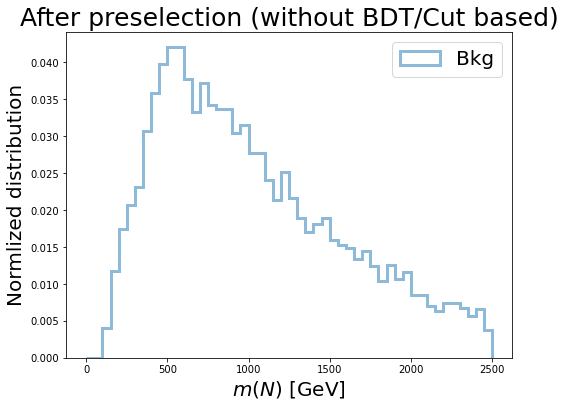

In [43]:
df_b = df[df.target==0]

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

ax1.hist(df_b['mN'], weights=[1/len(df_b)]*len(df_b), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Bkg');

# ax1.set_yscale('log')

ax1.set_title("After preselection (without BDT/Cut based)", fontsize=25)
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m(N) ~[\rmGeV]$', fontsize=20)
# ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)


In [55]:
np.unique(df.target)

array([0, 1, 2, 3, 4])

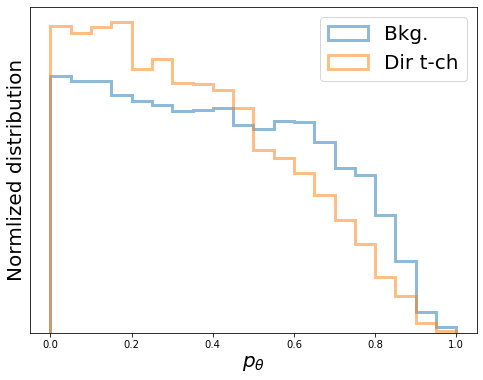

In [88]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


bins_=20
range_ = [0,1]
ax1.hist(df[df.target==0]['pTheta'], weights=[1/len(df[df.target==0])]*len(df[df.target==0]), bins=bins_, range=range_, histtype='step', label='Bkg.', lw=3, alpha=0.5);
# ax1.hist(df[df.target==1]['pTheta'], weights=[1/len(df[df.target==1])]*len(df[df.target==1]), bins=bins_, range=range_, histtype='step', label='Maj t-ch', lw=3, alpha=0.5);
# ax1.hist(df[df.target==2]['pTheta'], weights=[1/len(df[df.target==2])]*len(df[df.target==2]), bins=bins_, range=range_, histtype='step', label='Maj s-ch', lw=3, alpha=0.5);
ax1.hist(df[df.target==3]['pTheta'], weights=[1/len(df[df.target==3])]*len(df[df.target==3]), bins=bins_, range=range_, histtype='step', label='Dir t-ch', lw=3, alpha=0.5);
# ax1.hist(df[df.target==4]['pTheta'], weights=[1/len(df[df.target==4])]*len(df[df.target==4]), bins=bins_, range=range_, histtype='step', label='Dir s-ch', lw=3, alpha=0.5);

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_xlabel(r'$p_\theta$', fontsize=20)
ax1.legend(fontsize=20);